<a href="https://colab.research.google.com/github/shruthimohan03/Loan_approval_kaggle/blob/main/Ensemble-xgb-lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [305]:
import pandas as pd
data=pd.read_csv('/content/train.csv')
data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [306]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [307]:
# prompt: check imbalance class in column 'loan_status'

loan_status_counts = data['loan_status'].value_counts()
print(loan_status_counts)
print("\nPercentage of each class:")
print(loan_status_counts / len(data) * 100)
ratio_of_majority_to_minority_class = 50295 / 8350

loan_status
0    50295
1     8350
Name: count, dtype: int64

Percentage of each class:
loan_status
0    85.761787
1    14.238213
Name: count, dtype: float64


Preprocessing: Label Encoding

In [308]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Create a LabelEncoder object
le = LabelEncoder()

# Iterate through the columns and apply label encoding to object type columns
for column in data.columns:
  if data[column].dtype == object:
    data[column] = le.fit_transform(data[column])

Normalization

In [309]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the data using the scaler
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

print(data_normalized.head())


         id  person_age  person_income  person_home_ownership  \
0  0.000000    0.165049       0.016246               1.000000   
1  0.000017    0.019417       0.027324               0.666667   
2  0.000034    0.087379       0.012976               0.666667   
3  0.000051    0.097087       0.034708               1.000000   
4  0.000068    0.019417       0.029433               1.000000   

   person_emp_length  loan_intent  loan_grade  loan_amnt  loan_int_rate  \
0           0.000000          0.2    0.166667   0.159420       0.341011   
1           0.048780          0.6    0.333333   0.101449       0.445506   
2           0.065041          0.8    0.000000   0.159420       0.195506   
3           0.113821          1.0    0.166667   0.333333       0.319663   
4           0.016260          0.6    0.000000   0.159420       0.084270   

   loan_percent_income  cb_person_default_on_file  cb_person_cred_hist_length  \
0             0.204819                        0.0                    0.428571

In [346]:
# prompt: give code to train a lgbm model

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'loan_status' is your target variable
X = data_normalized.drop('loan_status', axis=1)
y = data_normalized['loan_status']

# Create a LightGBM dataset
train_data = lgb.Dataset(X, label=y)

# Define the parameters for the LightGBM model
params = {
    'objective': 'binary',  # For binary classification
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=100)

[LightGBM] [Info] Number of positive: 8350, number of negative: 50295
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1096
[LightGBM] [Info] Number of data points in the train set: 58645, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142382 -> initscore=-1.795644
[LightGBM] [Info] Start training from score -1.795644


XG BOOST + TREATING IMBALANCE CLASS PROBLEM (Using Class Weights in Models)

In [345]:
X = data_normalized.drop('loan_status', axis=1)
y = data_normalized['loan_status']
from xgboost import XGBClassifier
clf = XGBClassifier(scale_pos_weight=ratio_of_majority_to_minority_class)
'''colsample_bytree=0.9,
                    learning_rate=0.15,
                    min_child_weight=1,
                    max_depth=10,
                    n_estimators= 250,
                    subsample= 0.7'''
clf.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Importing the test data

In [347]:
test_data=pd.read_csv('/content/test.csv')
test_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


Preprocessing and normalizing

In [348]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Create a LabelEncoder object
le = LabelEncoder()

# Iterate through the columns and apply label encoding to object type columns
for column in test_data.columns:
  if test_data[column].dtype == object:
    test_data[column] = le.fit_transform(test_data[column])


In [349]:

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the data using the scaler
test_data_normalized = pd.DataFrame(scaler.fit_transform(test_data), columns=test_data.columns)

print(test_data_normalized.head())

         id  person_age  person_income  person_home_ownership  \
0  0.000000    0.040541       0.034283                    1.0   
1  0.000026    0.081081       0.048523                    0.0   
2  0.000051    0.081081       0.013713                    1.0   
3  0.000077    0.175676       0.024262                    1.0   
4  0.000102    0.081081       0.051688                    0.0   

   person_emp_length  loan_intent  loan_grade  loan_amnt  loan_int_rate  \
0           0.071429          0.4    0.833333   0.708455       0.619533   
1           0.142857          0.8    0.333333   0.271137       0.434991   
2           0.119048          1.0    0.666667   0.096210       0.705213   
3           0.095238          0.0    0.000000   0.183673       0.208508   
4           0.190476          0.4    0.500000   0.416910       0.653086   

   loan_percent_income  cb_person_default_on_file  cb_person_cred_hist_length  
0             0.493151                        0.0                    0.000000 

TESTING ON XGBOOST WITH IMBALANCE CLASS TREATMENT

In [326]:
# Make predictions on the test set
y_pred = clf.predict(test_data_normalized)

# Create a DataFrame with 'id' and 'loan_status'
submission_df = pd.DataFrame({'id': id, 'loan_status': y_pred})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission_xgb_tuning2.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('submission_xgb_tuning2.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TESTING ON LGBM

In [338]:
# Make predictions on the test set
y_pred = model.predict(test_data_normalized)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]
# Create a DataFrame with 'id' and 'loan_status'
submission_df = pd.DataFrame({'id': id, 'loan_status': y_pred})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission_lgbm.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('submission_lgbm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TESTING THE ENSEMBLE OF LGBM AND XGB

In [350]:
# prompt: i want to train an ensemble model with lgbm and xg boost

# Assuming you have already trained your XGBoost and LightGBM models (clf and model)
# and have your X_test and y_test data ready.

# Get predictions from both models
xgb_pred_proba = clf.predict_proba(test_data_normalized)[:, 1]
lgb_pred_proba = model.predict(test_data_normalized)

# Combine predictions using averaging or weighted averaging
ensemble_pred_proba = (xgb_pred_proba + lgb_pred_proba) / 2

# Convert ensemble predictions to binary class labels (0 or 1)
ensemble_pred_binary = [1 if p >= 0.5 else 0 for p in ensemble_pred_proba]

submission_df = pd.DataFrame({'id': id, 'loan_status': ensemble_pred_binary})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission_xgb-lgbm.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('submission_xgb-lgbm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Compare xgboost with eda and xg boost with only imbalance solving

In [20]:
xgboost_imb=pd.read_csv('/content/submission_xgb_imbalance.csv')
xgboost_eda=pd.read_csv('/content/submission_xgb_eda.csv')
accuracy4 = (xgboost_eda['loan_status'] == xgboost_imb['loan_status']).mean()
print(accuracy4)

0.9435520998516548


Compare xgb and ensemble of xgb-lgbm

In [351]:
xgboost_imb=pd.read_csv('/content/submission_xgb_imbalance.csv')
xgb_lgbm=pd.read_csv('/content/submission_xgb-lgbm.csv')
accuracy4 = (xgb_lgbm['loan_status'] == xgboost_imb['loan_status']).mean()
print(accuracy4)

0.945956314901018


MODELS WITH TEST AND TRAIN SPLIT TO CHECK ACCURACY

XG BOOST WITH IMBALANCE

In [324]:
X = data_normalized.drop('loan_status', axis=1)
y = data_normalized['loan_status']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from xgboost import XGBClassifier
clf = XGBClassifier(scale_pos_weight=ratio_of_majority_to_minority_class,
                    n_estimators=4096,
                    max_depth=12,
                    learning_rate=0.05,
                    booster='gbtree',
                    min_child_weight=1,
                    subsample=0.95,
                    colsample_bytree=0.65,
                    reg_lambda=1.00,
                    reg_alpha=1.00,
                    gamma= 1.00,
                    random_state=42,
                    objective='binary:logistic',
                    eval_metric='auc',
                    n_jobs=-1,)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.65, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4096, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [302]:
# prompt: do hyperparameter tuning for the above model

from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'max_depth': [9,10],            # Tree depth
    'min_child_weight': [1, 2],     # Min sum of instance weights in a child
    'gamma': [0, 0.1],            # Minimum loss reduction for split
    'subsample': [0.6, 0.8],      # Sample ratio for each tree
    'colsample_bytree': [0.9, 1.0], # Feature ratio per tree
    'learning_rate':[0.10, 0.15], # Step size shrinkage
    'n_estimators': [215, 300],    # Number of trees
    'scale_pos_weight': [ 7, ratio_of_majority_to_minority_class]  # Weighting for class imbalance
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Use the best model for predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

'''{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.15, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 250, 'scale_pos_weight': 6.023353293413174, 'subsample': 0.7}
Best accuracy found:  0.9467559049809748'''

KeyboardInterrupt: 

hyperparameter tuning 2

In [325]:
# prompt: give accuracy
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9475658623923608


NO eda + hyperparameter tuning

In [298]:
# prompt: give accuracy
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9425355955324409


In [304]:
# prompt: give accuracy
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9473100861113479


removing cols

In [261]:
# prompt: give accuracy
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9260806547872794


In [251]:
# prompt: give code to check roc-auc accuracy with x_test and y_test

from sklearn.metrics import roc_auc_score

y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC score: {roc_auc}")


ROC-AUC score: 0.9540741287703194


NO EDA

In [266]:
# prompt: give accuracy
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9349475658623924


In [245]:
# prompt: give code to check roc-auc accuracy with x_test and y_test

from sklearn.metrics import roc_auc_score

y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC score: {roc_auc}")

ROC-AUC score: 0.9519698718590407


LGBM USING TRAIN_TEST

In [332]:
# prompt: give code to train a lgbm model

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'loan_status' is your target variable
X = data_normalized.drop('loan_status', axis=1)
y = data_normalized['loan_status']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Define the parameters for the LightGBM model
params = {
    'objective': 'binary',  # For binary classification
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=100)

[LightGBM] [Info] Number of positive: 6708, number of negative: 40208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142979 -> initscore=-1.790765
[LightGBM] [Info] Start training from score -1.790765


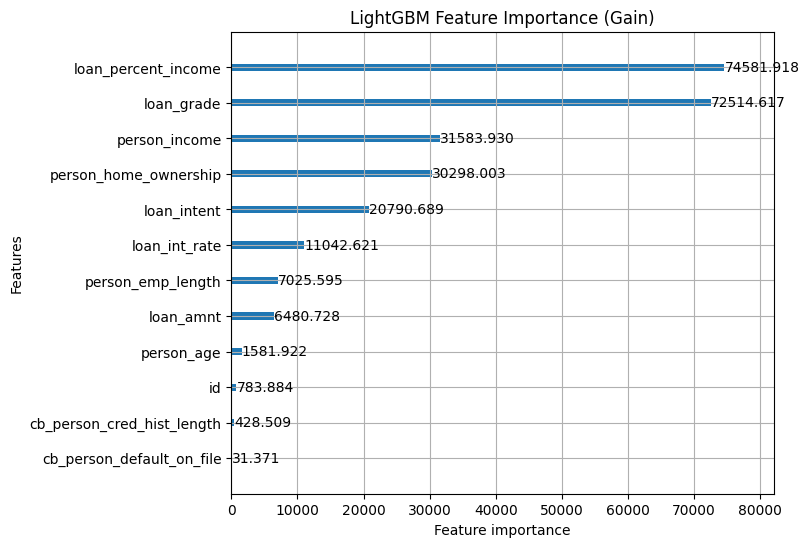

In [329]:
# Plot feature importance using Gain
import matplotlib.pyplot as plt
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

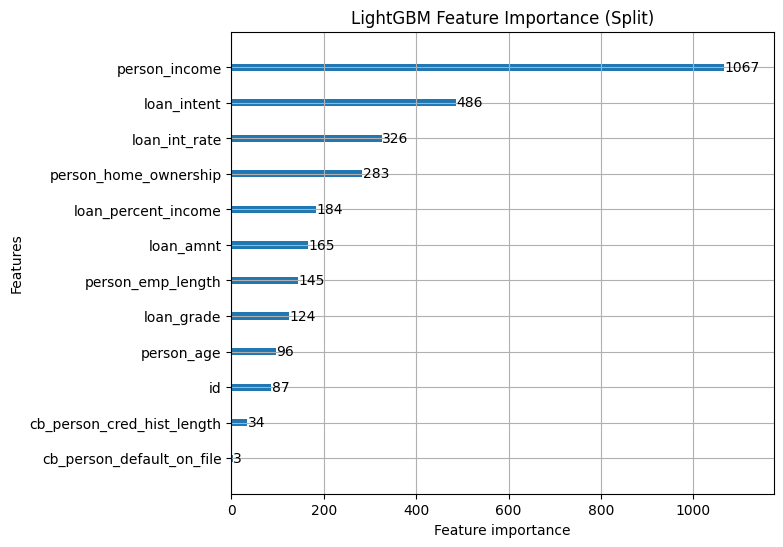

In [330]:
# Plot feature importance using Split
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [334]:
# prompt: give accuracy
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)

# Convert predictions to binary class labels (0 or 1) using a threshold (e.g., 0.5)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred] #This line converts the predicted probabilities into binary predictions

accuracy = accuracy_score(y_test, y_pred_binary)  # Use binary predictions for accuracy calculation
print(f"Accuracy: {accuracy}")

Accuracy: 0.9530224230539688


ENSEMBLE OF LGBM AND XGB

In [344]:
# prompt: i want to train an ensemble model with lgbm and xg boost

# Assuming you have already trained your XGBoost and LightGBM models (clf and model)
# and have your X_test and y_test data ready.

# Get predictions from both models
xgb_pred_proba = clf.predict_proba(X_test)[:, 1]
lgb_pred_proba = model.predict(X_test)

# Combine predictions using averaging or weighted averaging
ensemble_pred_proba = (xgb_pred_proba + lgb_pred_proba) / 2

# Convert ensemble predictions to binary class labels (0 or 1)
ensemble_pred_binary = [1 if p >= 0.5 else 0 for p in ensemble_pred_proba]

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_pred_binary)
print(f"Ensemble Accuracy: {ensemble_accuracy}")

ensemble_pred_proba = (0.6 * xgb_pred_proba + 0.4 * lgb_pred_proba)


# Calculate ROC-AUC score for the ensemble model
ensemble_roc_auc = roc_auc_score(y_test, ensemble_pred_proba)
print(f"Ensemble ROC-AUC score: {ensemble_roc_auc}")


Ensemble Accuracy: 0.9542160456986956
Ensemble ROC-AUC score: 0.9602390385135315


XGB_IMBALANCE (THE HIGHEST SCORE) & LGBM

In [337]:
xgboost_imb=pd.read_csv('/content/submission_xgb_imbalance.csv')
lgbm=pd.read_csv('/content/submission_lgbm.csv')
ensemble = (xgboost_imb + lgbm) / 2
ensemble

,id,loan_status
0,58645.0,0.959273
1,58646.0,0.015310
2,58647.0,0.724355
3,58648.0,0.013984
4,58649.0,0.060502
...,...,...
39093,97738.0,0.028221
39094,97739.0,0.007539
39095,97740.0,0.011206
39096,97741.0,0.128318
